In [6]:
import sys
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt

import hw5_part1 as hw5

In [7]:
# get the model from past 1
device = hw5.get_device()
model = hw5.NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

Using mps device


<All keys matched successfully>

In [8]:
# freeze the model weights
for param in model.parameters():
    param.requires_grad = False
    
# replace the last layer with custom
model.classify_stack[-1] = nn.Linear(in_features=50, out_features=3)

model.to(device)

print(model)

NeuralNetwork(
  (feature_maps_stack): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): Dropout2d(p=0.5, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
  )
  (classify_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=320, out_features=50, bias=True)
    (2): ReLU()
    (3): Linear(in_features=50, out_features=3, bias=True)
  )
)


In [9]:
# Import the greek stuff
from hw5_part3 import GreekTransform

training_set_path = "/Users/danielbi/git-repo/FALL23-CS5330/playground/pyTorch/data/greek_train"

# DataLoader for the Greek data set
greek_train_dataloader = torch.utils.data.DataLoader(
    datasets.ImageFolder(training_set_path,
                         transform = transforms.Compose([transforms.ToTensor(),
                                                         GreekTransform(),
                                                         transforms.Normalize((0.1307,),(0.3081,))
                                                         ])
                         ),
    batch_size = 5,
    shuffle = True )

greek_test_dataloader = torch.utils.data.DataLoader(
    datasets.ImageFolder(training_set_path,
                         transform = transforms.Compose([transforms.ToTensor(),
                                                         GreekTransform(),
                                                         transforms.Normalize((0.1307,),(0.3081,))
                                                         ])
                         ),
    batch_size = 5,
    shuffle = True )

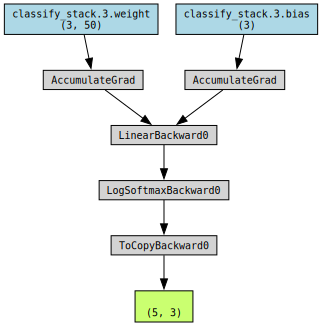

In [10]:
# visualize model
from torchviz import make_dot

examples = enumerate(greek_train_dataloader)
batch_idx, (example_data, example_targets) = next(examples)

sample_pred = model(example_data.to(device)).cpu()
make_dot(sample_pred, params=dict(model.named_parameters()))

In [11]:
validate_set_path = "/Users/danielbi/git-repo/FALL23-CS5330/playground/pyTorch/data/greek_test"

greek_valid_dataloader = torch.utils.data.DataLoader(
    datasets.ImageFolder(validate_set_path,
                         transform = transforms.Compose([transforms.Resize((28, 28)),
                                                         transforms.Grayscale(),
                                                         transforms.ToTensor(),
                                                         transforms.Normalize((0.1307,),(0.3081,))
                                                         ])
                         ),
    batch_size = 5,
    shuffle = True )


Shape of X [N, C, H, W]: torch.Size([5, 1, 28, 28])
Shape of y: torch.Size([5]) torch.int64
torch.Size([5])


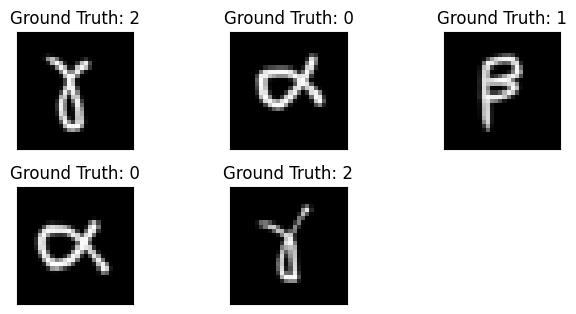

In [12]:
for X, y in greek_valid_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

examples = enumerate(greek_valid_dataloader)
batch_idx, (example_data, example_targets) = next(examples)

print(example_targets.shape)

fig = plt.figure()
for i in range(5):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

In [13]:
# set up the learning example again
learning_rate = 0.01
momentum = 0.5
log_interval = 100
n_epochs = 25
mnist_global_mean = 0.1307
mnist_global_stdev = 0.3081
random_seed = 1
batch_size_train = 64
batch_size_test = 1000
epochs = 5
train_losses = []
train_counter = []
test_losses = []
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [14]:
def validate_model(model, test_dataloader, device):
    # enable the testing mode
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_dataloader:
            # send the data to hardware device
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Compute the negative log likelihood loss
            test_loss += nn.functional.nll_loss(output, target, size_average=False).item()
            # Get the index of the maximum log-probability
            pred = output.data.max(1, keepdim=True)[1]
            # Count the number of correct predictions
            correct += pred.eq(target.data.view_as(pred)).sum()
    
    # Compute average loss        
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    return

def train_network_helper(train_dataloader, model, epoch, optimizer, device):
    model.train()
    for batch, (data, target) in enumerate(train_dataloader):
        # send the data to hardware device
        data, target = data.to(device), target.to(device)
        # reset zero gradients and forward pass in model
        optimizer.zero_grad()
        output = model(data)
        # compute loss function
        loss = nn.functional.nll_loss(output, target)
        # backward pass to computer gradients
        loss.backward()
        # update model with optimizer
        optimizer.step()

        if batch % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch * len(data), len(train_dataloader.dataset),
                100. * batch / len(train_dataloader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch*64) + ((epoch-1)*len(train_dataloader.dataset)))
            
            # torch.save(model.state_dict(), 'model.pth')
            # torch.save(optimizer.state_dict(), 'optimizer.pth')
    return

In [15]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
model = hw5.NeuralNetwork().to(device)


In [16]:
# validate_model(model, greek_test_dataloader, device)
for t in range(1, n_epochs + 1):
    print(f"Epoch {t+1}\n-------------------------------")
    train_network_helper(greek_train_dataloader, model, t, optimizer, device)
    validate_model(model, greek_test_dataloader, device)
print("Done!")

Epoch 2
-------------------------------
Train Epoch: 1 [0/27 (0%)]	Loss: 2.283404


/opt/homebrew/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.2551, Accuracy: 9/27 (33%)

Epoch 3
-------------------------------
Train Epoch: 2 [0/27 (0%)]	Loss: 2.284376

Test set: Avg. loss: 2.2551, Accuracy: 9/27 (33%)

Epoch 4
-------------------------------
Train Epoch: 3 [0/27 (0%)]	Loss: 2.216093

Test set: Avg. loss: 2.2551, Accuracy: 9/27 (33%)

Epoch 5
-------------------------------
Train Epoch: 4 [0/27 (0%)]	Loss: 2.280763

Test set: Avg. loss: 2.2551, Accuracy: 9/27 (33%)

Epoch 6
-------------------------------
Train Epoch: 5 [0/27 (0%)]	Loss: 2.292384

Test set: Avg. loss: 2.2551, Accuracy: 9/27 (33%)

Epoch 7
-------------------------------
Train Epoch: 6 [0/27 (0%)]	Loss: 2.226275

Test set: Avg. loss: 2.2551, Accuracy: 9/27 (33%)

Epoch 8
-------------------------------
Train Epoch: 7 [0/27 (0%)]	Loss: 2.223119

Test set: Avg. loss: 2.2551, Accuracy: 9/27 (33%)

Epoch 9
-------------------------------
Train Epoch: 8 [0/27 (0%)]	Loss: 2.372270

Test set: Avg. loss: 2.2551, Accuracy: 9/27 (33%)

Epoch 10
-

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='orange')
plt.scatter(test_counter, test_losses, color='green')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()